# The University of Hong Kong
## DASC7600 Data Science Project 2024
## Curves Similarity Analysis

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from typing import Dict, List, Tuple
from sklearn.metrics.pairwise import haversine_distances

# Constant
earth_radius_km = 6371

# Argument
lower_tri_matrix_ind = True # True, False

# Settings
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

%matplotlib inline

# Functions

In [2]:
def get_distance_between_two_columns(df: pd.DataFrame,
                                     col_A: str,
                                     col_B: str,
                                     order: int=1) -> float:
    num_list_A = df[col_A]
    num_list_B = df[col_B]
    
    if any(val != 0 for val in num_list_A):
        num_list_A = num_list_A / sum(num_list_A)
    
    if any(val != 0 for val in num_list_B):
        num_list_B = num_list_B / sum(num_list_B)
    
    return np.linalg.norm(num_list_A - num_list_B, order)


def get_distance_km(point_A: Tuple[float, float],
                    point_B: Tuple[float, float]) -> float:
    point_A_radius = [math.radians(x) for x in point_A]
    point_B_radius = [math.radians(x) for x in point_B]
    distance_matrix = haversine_distances([point_A_radius, point_B_radius])
    return float(distance_matrix[0, 1]) * earth_radius_km


def plot_case_count_line_chart(count_df: pd.DataFrame,
                               simlr_cntry_dict: Dict[str, List[str]],
                               cntry_cd: str,
                               norm_ind: bool=True) -> None:
    count_temp = count_df.copy()
    date_list = count_temp['report_date']
    
    cntry_cnt_list = count_temp[cntry_cd]
    if norm_ind == True:
        cntry_cnt_list /= sum(cntry_cnt_list)
            
    simlr_cntry_list = simlr_cntry_dict.get(cntry_cd)
    for simlr_cntry_cd in simlr_cntry_list:
        # Figure and axis
        fig, ax = plt.subplots(figsize=(16, 6))
        title_str = 'Number of New Covid-19 Cases'
        x_label_str = 'Date'
        y_label_str = 'New Case Counts'
        
        # Plot line chart
        simlr_cntry_cnt_list = count_temp[simlr_cntry_cd]
        if norm_ind == True:
            simlr_cntry_cnt_list /= sum(simlr_cntry_cnt_list)
            y_label_str = 'New Case Counts (Normalized)'
        
        ax.plot_date(date_list, cntry_cnt_list,
                     marker='', linestyle='-', label=cntry_cd)
        
        ax.plot_date(date_list, simlr_cntry_cnt_list,
                     marker='', linestyle='-', label=simlr_cntry_cd)
        
        # Title, x-axis label and y-axis label
        plt.title(title_str) 
        plt.xlabel(x_label_str)
        plt.ylabel(y_label_str)
        
        # Legend
        plt.legend(loc="upper right")
        
        plt.show()

# Load Data

In [3]:
# Read csv files
covid_global_new_case_count_std = pd.read_csv('./data/std_data/global/covid_global_new_case_count_std.csv')
global_lat_long_std = pd.read_csv('./data/std_data/global/global_lat_long_std.csv')

# Analysis

In [4]:
# Modify datatype for the date column
covid_global_new_case_count_std['report_date'] = pd.to_datetime(covid_global_new_case_count_std['report_date'],  format='%Y%m%d')

In [5]:
# Mapping Tables
global_lat_long_std.set_index('cntry_cd', inplace=True)
## Contry code to latitude and longitude
cntry_lat_long_dict = global_lat_long_std[['lat','long']].to_dict('index')
## Contry code to country name
cntry_name_dict = global_lat_long_std[['cntry_name']].to_dict('index')

In [6]:
# Matrix with distance between columns
col_list = [col for col in covid_global_new_case_count_std.columns \
                if "DATE" not in col.upper()]

col_nbr = len(col_list)

col_dist_matrix = np.empty((col_nbr, col_nbr), dtype=float)
for i, col_A in enumerate(col_list):
    for j, col_B in enumerate(col_list):
        col_dist_matrix[i, j] = \
            get_distance_between_two_columns(covid_global_new_case_count_std, col_A, col_B)

if lower_tri_matrix_ind:
    col_dist_matrix = np.tril(col_dist_matrix, -1)

col_dist_matrix_df = pd.DataFrame(data=col_dist_matrix,
                                  index=col_list,
                                  columns=col_list)

In [7]:
# The pairs of similar countries
thrhld = 0.4

simlr_cntry_dict = {}
for col in col_list:
    index_list = list(col_dist_matrix_df[(col_dist_matrix_df[col] > 0) & \
                                         (col_dist_matrix_df[col] <= thrhld)] \
                          .index.values)
    if len(index_list) > 0:
        print(f'{col}: {str(index_list)[1:-1]}')
        simlr_cntry_dict[col] = index_list

print('')
print(f'There are {len(simlr_cntry_dict)} counties with new case counts similar to other countries (threshold: {thrhld}).')

AD: 'ES'
AT: 'DE', 'LI'
BA: 'MK'
BG: 'HR', 'RS'
CH: 'LI'
CY: 'GR'
CZ: 'PL'
DK: 'NO'
EC: 'PE'
EE: 'LV'
FR: 'IT', 'LU', 'MC'
GB: 'IE'
HU: 'PL'
IT: 'LU', 'SM'
LT: 'LV'
MD: 'RS'
XXG: 'XXI'

There are 17 counties with new case counts similar to other countries (threshold: 0.4).


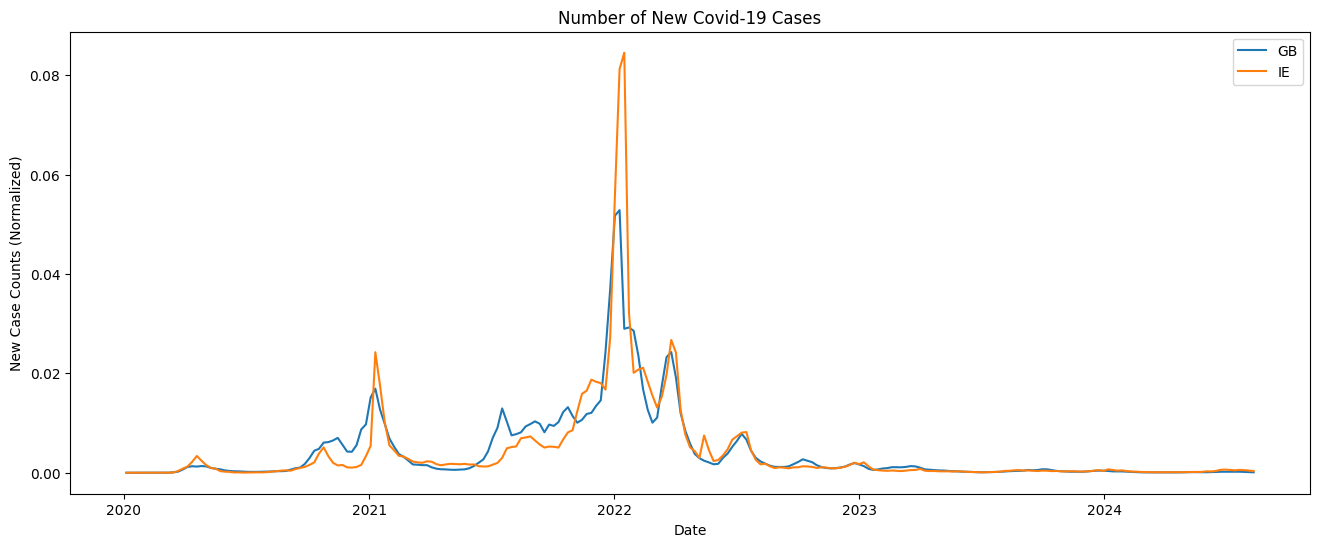

In [8]:
# To validate the result by plotting the line charts
plot_case_count_line_chart(covid_global_new_case_count_std,
                           simlr_cntry_dict,
                           'GB',
                           True)

In [9]:
# Print the country names, latitude, longitude for each pair and their distance
for cntry_cd, simlr_cntry_list in simlr_cntry_dict.items():
    try:
        cntry_name = cntry_name_dict[cntry_cd]['cntry_name']
        cntry_lat = cntry_lat_long_dict[cntry_cd]['lat']
        cntry_long = cntry_lat_long_dict[cntry_cd]['long']
    except:
        cntry_name = 'Unknown Country'
        cntry_lat = cntry_long = np.nan
    
    print(f'For the country {cntry_cd} - {cntry_name} (lat: {cntry_lat:.2f}, long: {cntry_long:.2f}),')
    print(f'It has new case counts similar to {len(simlr_cntry_list)} country/countries.')
    for simlr_cntry_cd in simlr_cntry_list:
        try:
            simlr_cntry_name = cntry_name_dict[simlr_cntry_cd]['cntry_name']
            simlr_cntry_lat = cntry_lat_long_dict[simlr_cntry_cd]['lat']
            simlr_cntry_long = cntry_lat_long_dict[simlr_cntry_cd]['long']
        except:
            simlr_cntry_name = 'Unknown Country'
            simlr_cntry_lat = simlr_cntry_long = np.nan
        
        try:
            distance_km = get_distance_km((cntry_lat, cntry_long), (simlr_cntry_lat, simlr_cntry_long))
        except:
            distance_km = np.nan
        
        print(f'Distance to {simlr_cntry_cd} - {simlr_cntry_name} (lat: {simlr_cntry_lat:.2f}, long: {simlr_cntry_long:.2f}):',
              f'{distance_km:.1f} km')
    print('')

For the country AD - Andorra (lat: 42.55, long: 1.60),
It has new case counts similar to 1 country/countries.
Distance to ES - Spain (lat: 40.46, long: -3.75): 502.0 km

For the country AT - Austria (lat: 47.52, long: 14.55),
It has new case counts similar to 2 country/countries.
Distance to DE - Germany (lat: 51.17, long: 10.45): 502.7 km
Distance to LI - Liechtenstein (lat: 47.17, long: 9.56): 378.3 km

For the country BA - Bosnia and Herzegovina (lat: 43.92, long: 17.68),
It has new case counts similar to 1 country/countries.
Distance to MK - Macedonia [FYROM] (lat: 41.61, long: 21.75): 419.4 km

For the country BG - Bulgaria (lat: 42.73, long: 25.49),
It has new case counts similar to 2 country/countries.
Distance to HR - Croatia (lat: 45.10, long: 15.20): 864.2 km
Distance to RS - Serbia (lat: 44.02, long: 21.01): 389.1 km

For the country CH - Switzerland (lat: 46.82, long: 8.23),
It has new case counts similar to 1 country/countries.
Distance to LI - Liechtenstein (lat: 47.17, l